# DATA ANALYSIS

In [1]:
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap
import numpy as np
import csv
import matplotlib.pyplot as plt
import json
import re
from matplotlib.colors import Normalize

In [2]:
with open('../Data/sequences.csv', 'r') as f:
    reader = csv.reader(f)
    sequences = list(reader)

In [3]:
f = open('../Data/data.json')
data = json.load(f)

a = open('../Data/added_data.json')
added_data = json.load(a)

In [4]:
model= word2vec.Word2Vec.load('../Data/Models/model_5e_100d.model')

In [5]:
# Create a dictionary to map addresses to their corresponding embeddings
journey_embeddings = {}
for journey in sequences:
    for place in journey:
        try:
            journey_id = place  # Convert the journey list to a tuple to use as a dictionary key
            journey_embeddings[journey_id] = model.wv[journey_id]
        except KeyError:
            # Handle cases where the journey is not present in the Word2Vec model
            pass

# Convert dictionary to numpy array
X = np.array(list(journey_embeddings.values()))

# Create a list of all addresses
journey_ids = list(journey_embeddings.keys())

# Create a dictionary mapping addresses to their index in the numpy array
journey_idx = {journey_id: idx for idx, journey_id in enumerate(journey_ids)}

In [6]:
X = model.wv.vectors

#pacmap
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_pacmap = embedding.fit_transform(X, init="pca")

# tsne
def tsne_plot(X):
    X=np.array(X)
    proj = TSNE(perplexity=20).fit_transform(X)
    return proj
proj_tsne=tsne_plot(X)

# UMAP 
proj_umap = umap.UMAP(n_components=2, n_neighbors=20, metric='cosine').fit_transform(X)

# pca 
pca = PCA(n_components=2)
proj_pca=pca.fit_transform(X)


_____________________________________________________________________

# COUNT

In [7]:
counts_to_labels = {100: '0-100', 1000: '101-1000', 5000: '1001-5000', 10000: '5001-10000', 50000: '10000-50000', 100000: '50001-100000', 1000001: '100000+'}

In [8]:
address_count_seq = {}
for seq in sequences:
    for place in seq:
        if place in address_count_seq:
            address_count_seq[place] += 1
        else:
            address_count_seq[place] = 1


from collections import Counter

# Count occurrences of each number of mentions of addresses. So counting how many addresses was mentioned once and so on
address_counts = Counter(address_count_seq.values())

# Sort the counts by their keys (number of mentions), in descending order
sorted_counts = sorted(address_counts.items(), key=lambda x: x[0], reverse=True)

In [9]:

address_cluster_count = {}

for address in address_count_seq.keys():
      count = address_count_seq[address]
      if 0 <= count <= 100:
         address_cluster_count[address] = 100
      elif 101 <= count <= 1000:
         address_cluster_count[address] = 1000
      elif 1001 <= count <= 5000:
         address_cluster_count[address] = 5000
      elif 5001 <= count <= 10000:
         address_cluster_count[address] = 10000
      elif 10001 <= count <= 50000:
         address_cluster_count[address] = 50000
      elif 50001 <= count <= 100000:
         address_cluster_count[address] = 100000
      elif 100001 <= count:
         address_cluster_count[address] = 1000001
      else:
         print("address was: ", address)
         address_cluster_count[address] = 0 


In [10]:
from collections import Counter

# Count occurrences of each zip code
count_counts = Counter(address_cluster_count.values())

# Print the zip code counts
for occurrence, count in sorted(count_counts.items()):
    print(f"Count {occurrence}: {count} occurrences")

Count 100: 4063 occurrences
Count 1000: 833 occurrences
Count 5000: 265 occurrences
Count 10000: 57 occurrences
Count 50000: 76 occurrences
Count 100000: 22 occurrences
Count 1000001: 9 occurrences


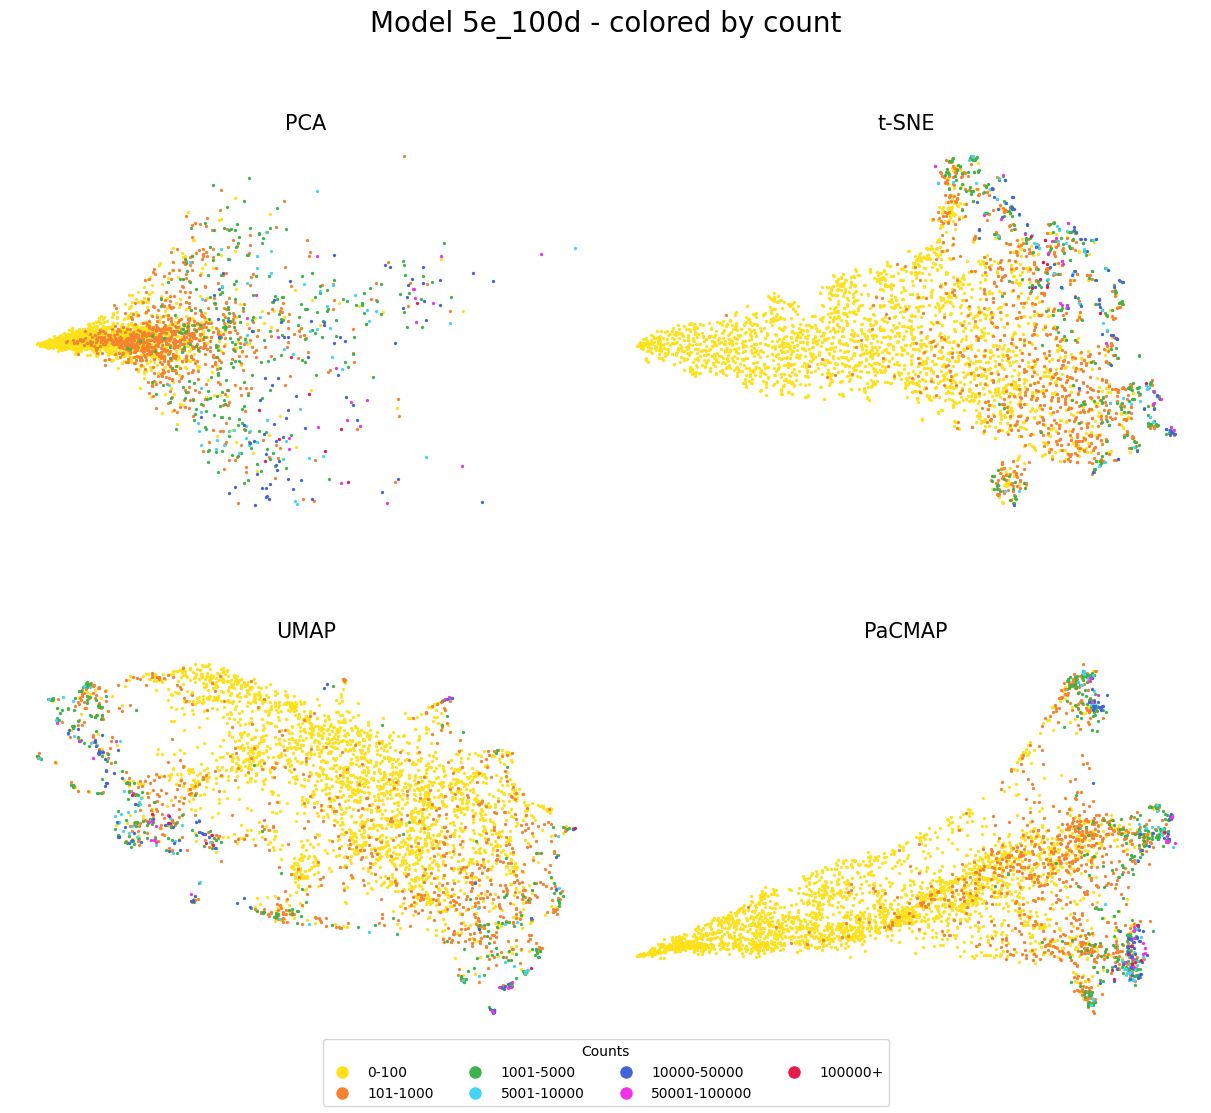

In [113]:

# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

fig, ax = plt.subplots(2, 2, figsize=(12, 10), layout="constrained", gridspec_kw={'wspace': 0.0, 'hspace': 0.2})
xs = [proj_pca, proj_tsne, proj_umap, proj_pacmap]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=15)

        for current_count_code in unique_count_codes:
            relevant_addresses = []
            for address, count_code in address_cluster_count.items():
                if address in journey_ids:
                    if current_count_code == count_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_count_code, c=count_colors[current_count_code]
            )
        #  # Add labels to stations makes it impossible to read 
        #     for journey_id in relevant_journeys_zip:
        #         x_coord = xs[s][journey_idx[journey_id]][0]
        #         y_coord = xs[s][journey_idx[journey_id]][1]
        #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
            
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
fig.legend(handles= handles, loc="outside lower center", ncol=4, title='Counts')
fig.suptitle('Model 5e_100d - colored by count', fontsize=20, y=1.1)
plt.show()


### Metro

In [103]:
stations_with_metro = []
for location in journey_ids:
    if '(Metro)' in location:
        stations_with_metro.append(location)

City = ["Nørrebro St. (Metro)", "Nørrebros Runddel St. (Metro)", "Nuuks Plads St. (Metro)", "Axelm Møllers Have St. (Metro)", 
      "Frederiksberg St. (Metro)", "Frederiksberg Allé St. (Metro)", "Enghave Plads St. (Metro)", "København H St. (Metro)", "København H (Metro)",
      "Rådhuspladsen St. (Metro)", "Gammel Strand St. (Metro)", "Kongens Nytorv St. (Metro)", "Marmorkirken St. (Metro)",
       "Østerport St. (Metro)", "Trianglen St. (Metro)", "Poul Henningsens Plads St. (Metro)", "Vibenhus Runddel St. (Metro)",
        "Skjolds Plads St. (Metro)", "Nordhavn St. (Metro)", "Orientkaj St. (Metro)"]

M1_2 = ["Vanløse St. (Metro)", "Flintholm St. (Metro)", "Lindevang St. (Metro)", "Fasanvej St. (Metro)", 
      "Frederiksberg St. (Metro)", "Forum St. (Metro)", "Nørreport St. (Metro)", "Kongens Nytorv St. (Metro)",
      "Christianshavn St. (Metro)"]
M1 = ["Islands Brygge St. (Metro)", "DR Byen St. (Metro)", "Sundby St. (Metro)", "Bella Center St. (Metro)", "Ørestad St. (Metro)", "Vestamager St. (Metro)"]
M2 = ["Amagerbro St. (Metro)", "Lergravsparken St. (Metro)", "Øresund St. (Metro)",
      "Amager Strand St. (Metro)", "Femøren St. (Metro)", "Kastrup St. (Metro)", "Københavns Lufthavn St. (Metro)"]

#color_to_metro= {"City": "Red", "M2": "Yellow", "M1": "Green", "M1_2": "Purple", "Metro": "Black"}
color_to_metro= {"Red": "City" , "Yellow":  "M2", "Green": "M1", "Purple": "M1_2"}

# Create the plots

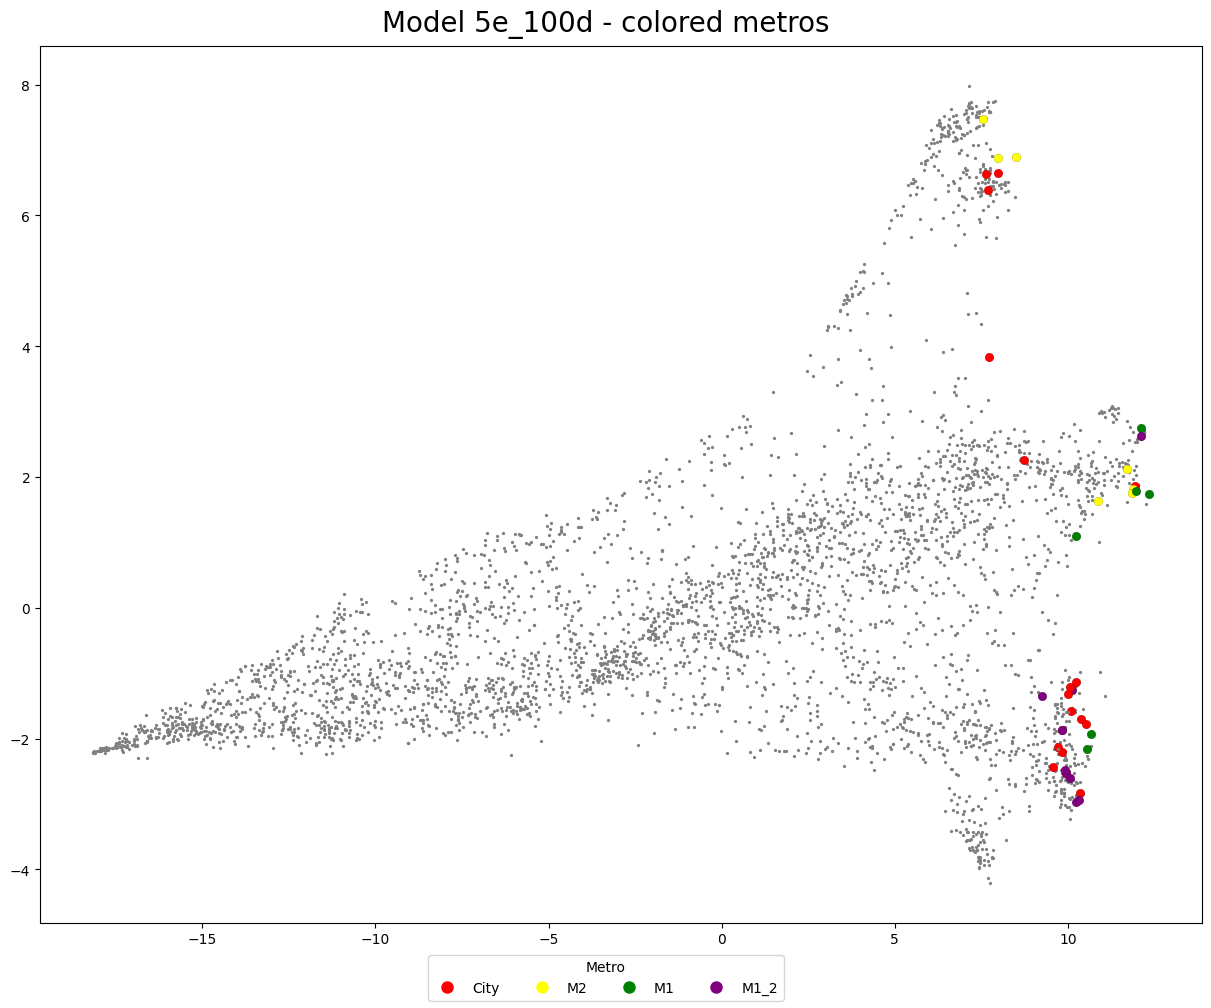

In [106]:
# Define color palette for zip codes
unique_metroes = color_to_metro.keys()
color_palette = ["Red", "Yellow", "Green", "Purple"]
colors = {}
for idx, metro in enumerate(unique_metroes):
    colors[metro] = color_palette[idx]


fig, ax = plt.subplots(1, 1, figsize=(12, 10), layout="constrained")


for current_count_code in unique_count_codes:
    relevant_addresses = []
    for address, count_code in address_cluster_count.items():
        if address in journey_ids:
            if current_count_code == count_code:
                relevant_addresses.append(address)

    relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
    #plot all without metro
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id not in stations_with_metro],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id not in stations_with_metro],
        lw=0.1, s=5, label=current_count_code, facecolor='grey'
    )

    # plt.scatter(
    #     [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in stations_with_metro],
    #     [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in stations_with_metro],
    #     lw=0.1, s=40, label=current_count_code, edgecolors='black', facecolor='none'
    # )

    #Plot all city
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in City],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in City],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Red', label="City"
    )

    #Plot all m1_2
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in M1_2],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in M1_2],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Purple', label="M1_2"
    )

    #Plot all m2
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in M2],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in M2],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Yellow', label="M2"
    )

      #Plot all m1
    plt.scatter(
        [proj_pacmap[journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip if journey_id in M1],
        [proj_pacmap[journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip if journey_id in M1],
        lw=0.1, s=40, marker='o', edgecolor='black', facecolor='Green', label="M1"
    )


# for journey_id in stations_with_metro:
#     x_coord = proj_pacmap[journey_idx[journey_id]][0]
#     y_coord = proj_pacmap[journey_idx[journey_id]][1]
#     plt.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=colors[metro], label=color_to_metro[metro]) for metro in unique_metroes]
fig.legend(handles= handles, loc="outside lower center", ncol=5, title='Metro')
fig.suptitle('Model 5e_100d - colored metros', fontsize=20)

plt.show()

_____________________________________________________________________

# ZIPCODES

In [14]:
def getZip(info):
    pattern_zip = '\d{4}'
    pattern_denmark = 'anmark'
    match_zip = re.search(pattern_zip, info)
    match_denmark = re.search(pattern_denmark, info)
    if match_zip is not None and match_denmark is not None:
        return match_zip.group()
    else :
        return
    

In [15]:
pattern = r'\d.*'

def get_modified (location):
    location = (re.sub(pattern, '', location)).strip()
    if location == '':
        return
    if location[-1] == '(':
        location = location[:-1]
    if location == 'Zoo':
        location = "Zoologisk Have"
    return location


In [16]:
address_cluster_zips = {}
zip_to_label = {'1000': 'Kbh K', '1700': 'Vesterbro', '2000': 'Frederiksberg', '2100': 'Østerbro', '2200': 'Nørrebro', 
                '2300': 'Kbh S', '2400': 'Kbh NV', '2500': 'Valby', '2600': 'Glostrup', '2700': 'Brønshøj', '2800': 'Lyngby', '2900': 'Hellerup', '2770': 'Kastrup'}
zip_to_label_clustered = {'2800': 'Nord', '1000': 'Midt', '2600': 'Vest', '2300' : 'Syd'}
wrong_addresses = []

In [17]:

for address, info in data.items():
    if info is not None: 
        zip_code = getZip(info['address'])  # Extract zip code from address can be empty
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 4999: #for now removing all failed zipcodes in Jylland
                if 1000 <= zip <= 1499:
                    #Kbh K
                    address_cluster_zips[address] = '1000'
                elif 1500 <= zip <= 1799:
                    #Kbh V
                    address_cluster_zips[address] = '1700'
                elif zip == 2000:
                    #Frederiksberg C
                    address_cluster_zips[address] = '2000'
                elif 2000 < zip < 2200: #2150 er Nordhavn
                    #Østerbro
                    address_cluster_zips[address] = '2100'
                elif 2200 <= zip < 2300:
                    #København N (Nørrebro)
                    address_cluster_zips[address] = '2200'
                elif 2300 <= zip < 2400:
                    #Amager Kbh S
                    address_cluster_zips[address] = '2300'
                elif 2400 <= zip < 2500:
                    #Kbh NV
                    address_cluster_zips[address] = '2400'
                elif 2500 <= zip < 2600:
                    #Valby
                    address_cluster_zips[address] = '2500'
                elif 2600 <= zip < 2700:
                    #Glostrup
                    address_cluster_zips[address] = '2600'
                elif zip == 2770 or zip == 2791:
                    #Kastrup Dragør
                    address_cluster_zips[address] = '2770'
                elif 2700 <= zip < 2800:
                    #Brønshøj
                    address_cluster_zips[address] = '2700'
                elif 2800 <= zip < 2900:
                    #Lyngby
                    address_cluster_zips[address] = '2800'
                elif 2800 <= zip < 2900:
                    #Hellerup
                    address_cluster_zips[address] = '2900'
            else: 
                wrong_addresses.append(address) #go through later


#run through the list of wrong addresses and try to find them in the added_data.json file to get the "correct" zipcode
for address in wrong_addresses:
    #find in json file
    if address in added_data:
        zip_code = getZip(added_data[address]['address'])
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 4999: #for now removing all failed zipcodes in Jylland
                if 1000 <= zip <= 1499:
                    #Kbh K
                    address_cluster_zips[address] = '1000'
                elif 1500 <= zip <= 1799:
                    #Kbh V
                    address_cluster_zips[address] = '1700'
                elif zip == 2000:
                    #Frederiksberg C
                    address_cluster_zips[address] = '2000'
                elif 2000 < zip < 2200: #2150 er Nordhavn
                    #Østerbro
                    address_cluster_zips[address] = '2100'
                elif 2200 <= zip < 2300:
                    #København N (Nørrebro)
                    address_cluster_zips[address] = '2200'
                elif 2300 <= zip < 2400:
                    #Amager Kbh S
                    address_cluster_zips[address] = '2300'
                elif 2400 <= zip < 2500:
                    #Kbh NV
                    address_cluster_zips[address] = '2400'
                elif 2500 <= zip < 2600:
                    #Valby
                    address_cluster_zips[address] = '2500'
                elif 2600 <= zip < 2700:
                    #Glostrup
                    address_cluster_zips[address] = '2600'
                elif zip == 2770 or zip == 2791:
                    #Kastrup Dragør
                    address_cluster_zips[address] = '2770'
                elif 2700 <= zip < 2800:
                    #Brønshøj
                    address_cluster_zips[address] = '2700'
                elif 2800 <= zip < 2900:
                    #Lyngby
                    address_cluster_zips[address] = '2800'
                elif 2800 <= zip < 2900:
                    #Hellerup
                    address_cluster_zips[address] = '2900'

In [18]:
from collections import Counter

# Count occurrences of each zip code
zip_code_counts = Counter(address_cluster_zips.values())

# Print the zip code counts
for zip_code, count in zip_code_counts.items():
    print(f"Zip code {zip_code}: {count} addresses")

Zip code 2100: 3345 addresses
Zip code 2400: 3539 addresses
Zip code 1000: 3995 addresses
Zip code 2300: 6497 addresses
Zip code 2500: 2205 addresses
Zip code 1700: 2522 addresses
Zip code 2770: 2999 addresses
Zip code 2800: 413 addresses
Zip code 2000: 1921 addresses
Zip code 2200: 2916 addresses
Zip code 2700: 2554 addresses
Zip code 2600: 797 addresses


In [19]:
# New dictionary to store modified keys and their corresponding zip codes
modified_new_address_cluster_zips = {}

# Iterate through the keys, apply regex operation, and update the new dictionary
for address, zipcode in address_cluster_zips.items():
    new_address = get_modified(address)
    modified_new_address_cluster_zips[new_address] = zipcode


/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_8088/3659850241.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_8088/3659850241.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  col.scatter(


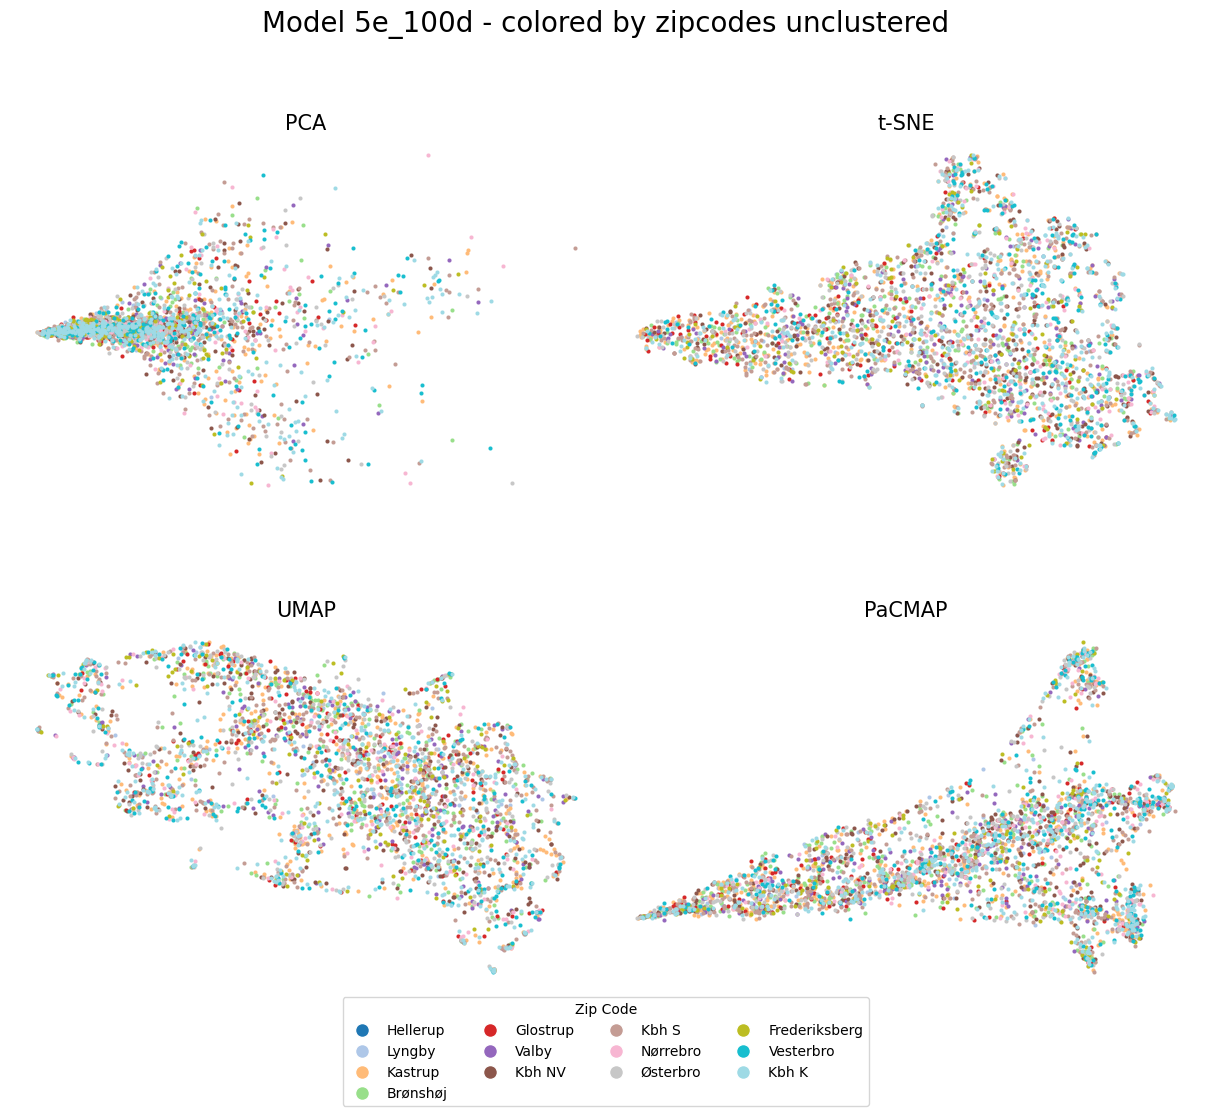

In [117]:

zip_colors = {}  # Dictionary to map zip codes to colors
unique_zip_codes = sorted(zip_to_label.keys(), reverse=True)
num_colors = len(unique_zip_codes) 
color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap

for idx, zip_code in enumerate(unique_zip_codes):
    zip_colors[zip_code] = color_palette(idx)

# Create the plots
fig, ax = plt.subplots(2, 2, figsize=(12, 10), layout='constrained', gridspec_kw={'wspace': 0.0, 'hspace': 0.2})
xs = [proj_pca, proj_tsne, proj_umap, proj_pacmap]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

#should be two times two
for row in ax:
    for col in row:
        #print("One plot")
        col.set_title(ts[s], fontsize=15)
        # # Filter journeys by field

        for current_zip_code in unique_zip_codes:
            # Plot all journeys for each zip code
            relevant_addresses = []
            for address, zip_code in modified_new_address_cluster_zips.items():
                if address in journey_ids:
                    if current_zip_code == zip_code:
                        relevant_addresses.append(address)

            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=8, label=current_zip_code, c=zip_colors[current_zip_code]
            )
        s += 1
        col.axis('off')

# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=zip_colors[zip_code], label=zip_to_label[zip_code]) for zip_code in unique_zip_codes]
fig.legend(handles= handles, loc="outside lower center", ncol=4, title='Zip Code')
fig.suptitle('Model 5e_100d - colored by zipcodes unclustered', fontsize=20, y=1.1)
plt.show()


### More clustered

In [21]:
#Nord, Midt, Vest, Syd
for address, info in data.items():
    if info is not None: 
        zip_code = getZip(info['address'])  # Extract zip code from address can be empty
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 4999: #for now removing all failed zipcodes in Jylland
                        if 1000 <= zip <= 1499:
                            #Kbh K
                            address_cluster_zips[address] = '1000'
                        elif 1500 <= zip <= 1799:
                            #Kbh V
                            address_cluster_zips[address] = '1000'
                        elif zip == 2000:
                            #Frederiksberg C
                            address_cluster_zips[address] = '1000'
                        elif 2000 < zip < 2200: #2150 er Nordhavn
                            #Østerbro
                            address_cluster_zips[address] = '1000'
                        elif 2200 <= zip < 2300:
                            #København N (Nørrebro)
                            address_cluster_zips[address] = '1000'
                        elif 2300 <= zip < 2400:
                            #Amager Kbh S
                            address_cluster_zips[address] = '2300'
                        elif 2400 <= zip < 2500:
                            #Kbh NV
                            address_cluster_zips[address] = '1000'
                        elif 2500 <= zip < 2600:
                            #Valby
                            address_cluster_zips[address] = '2300'
                        elif 2600 <= zip < 2700:
                            #Glostrup
                            address_cluster_zips[address] = '2600'
                        elif zip == 2770 or zip == 2791:
                            #Kastrup Dragør
                            address_cluster_zips[address] = '2300'
                        elif 2700 <= zip < 2800:
                            #Brønshøj
                            address_cluster_zips[address] = '1000'
                        elif 2800 <= zip < 2900:
                            #Lyngby
                            address_cluster_zips[address] = '2800'
                        elif 2800 <= zip < 2900:
                            #Hellerup
                            address_cluster_zips[address] = '2800'
            else: 
                wrong_addresses.append(address) #go through later


#run through the list of wrong addresses and try to find them in the added_data.json file to get the "correct" zipcode
for address in wrong_addresses:
    #find in json file
    if address in added_data:
        zip_code = getZip(added_data[address]['address'])
        if zip_code is not None:
            zip = int(zip_code)
            if 1000 <= zip <= 1499:
                #Kbh K
                address_cluster_zips[address] = '1000'
            elif 1500 <= zip <= 1799:
                #Kbh V
                address_cluster_zips[address] = '1000'
            elif zip == 2000:
                #Frederiksberg C
                address_cluster_zips[address] = '1000'
            elif 2000 < zip < 2200: #2150 er Nordhavn
                #Østerbro
                address_cluster_zips[address] = '1000'
            elif 2200 <= zip < 2300:
                #København N (Nørrebro)
                address_cluster_zips[address] = '1000'
            elif 2300 <= zip < 2400:
                #Amager Kbh S
                address_cluster_zips[address] = '2300'
            elif 2400 <= zip < 2500:
                #Kbh NV
                address_cluster_zips[address] = '1000'
            elif 2500 <= zip < 2600:
                #Valby
                address_cluster_zips[address] = '2300'
            elif 2600 <= zip < 2700:
                #Glostrup
                address_cluster_zips[address] = '2600'
            elif zip == 2770 or zip == 2791:
                #Kastrup Dragør
                address_cluster_zips[address] = '2300'
            elif 2700 <= zip < 2800:
                #Brønshøj
                address_cluster_zips[address] = '1000'
            elif 2800 <= zip < 2900:
                #Lyngby
                address_cluster_zips[address] = '2800'
            elif 2800 <= zip < 2900:
                #Hellerup
                address_cluster_zips[address] = '2800'

In [22]:
# New dictionary to store modified keys and their corresponding zip codes
modified_address_cluster_zips = {}

# Iterate through the keys, apply regex operation, and update the new dictionary
for address, zipcode in address_cluster_zips.items():
    new_address = get_modified(address)
    modified_address_cluster_zips[new_address] = zipcode


/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_8088/2470452665.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('Set3', num_colors)  # Choose a colormap
/var/folders/z3/0j97vknj4696wz9q6_jg32240000gn/T/ipykernel_8088/2470452665.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  col.scatter(


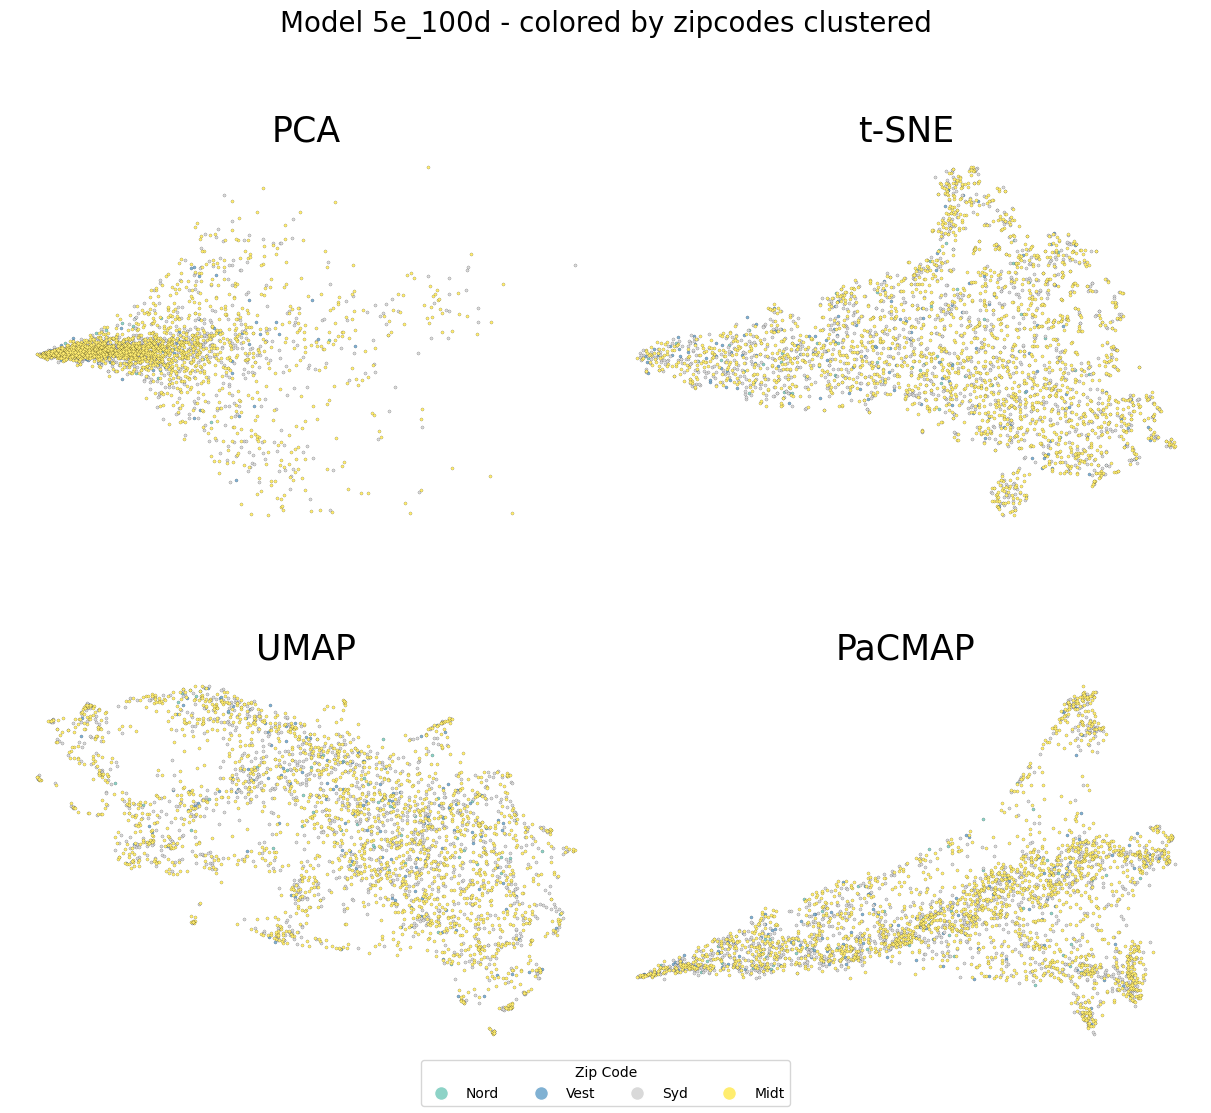

In [126]:

zip_colors = {}  # Dictionary to map zip codes to colors
unique_zip_codes = sorted(zip_to_label_clustered.keys(), reverse=True)
num_colors = len(unique_zip_codes) #change this
color_palette = plt.cm.get_cmap('Set3', num_colors)  # Choose a colormap

for idx, zip_code in enumerate(unique_zip_codes):
    zip_colors[zip_code] = color_palette(idx)

fig, ax = plt.subplots(2, 2, figsize=(12, 10), layout='constrained', gridspec_kw={'wspace': 0.0, 'hspace': 0.2})
xs = [proj_pca, proj_tsne, proj_umap, proj_pacmap]  # Use xs to select different dimensionality reduction results
ts = ["PCA", "t-SNE", "UMAP", "PaCMAP"]
s = 0

for row in ax:
    for col in row:
        col.set_title(ts[s], fontsize=25)
        for current_zip_code in unique_zip_codes:
            # Plot all journeys for each zip code
            relevant_addresses = []
            for address, zip_code in modified_address_cluster_zips.items():
                if address in journey_ids:
                    if current_zip_code == zip_code:
                        relevant_addresses.append(address)
            relevant_journeys_zip = [journey_id for journey_id in relevant_addresses]
            col.scatter(
                [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_zip],
                [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_zip],
                lw=0.1, s=5, label=current_zip_code, edgecolors='black',  c=zip_colors[current_zip_code]
            )

        s += 1
        col.axis('off')

# Custom legend

handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor=zip_colors[zip_code], label=zip_to_label_clustered[zip_code]) for zip_code in unique_zip_codes]
fig.legend(handles= handles, loc="outside lower center", ncol=4, title='Zip Code')
fig.suptitle('Model 5e_100d - colored by zipcodes clustered', fontsize=20, y=1.1)
plt.show()


_____________________________________________________________________

# SIMILARITY - EMBEDDING VALIDATION

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming X is your embeddings_matrix
embeddings_matrix = X.shape

# Calculate cosine similarity matrix between station vectors
similarity_matrix = cosine_similarity(X)

highest = -1
for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        if i != j and similarity_matrix[i, j] > highest:
            highest = similarity_matrix[i, j]

print(highest)

# Find the indices of the maximum similarity score in the updated matrix
max_indices = np.argwhere(similarity_matrix == highest)

# Extract the indices of the most similar pair
most_similar_pair_indices = max_indices[0]

# Get the station names corresponding to the indices
station_names = model.wv.index_to_key
station_i_name = station_names[most_similar_pair_indices[0]]
station_j_name = station_names[most_similar_pair_indices[1]]

# Print the names of the two most similar stations
print(f"The two most similar stations (not the same) are: {station_i_name} and {station_j_name}")

# # X is your numpy array containing the embedding vectors. Each row of X represents a vector in the embedding space.
# # cosine_similarity(X) computes the cosine similarity between all pairs of vectors in X.
# # The resulting similarity_matrix is a symmetric matrix where each element similarity_matrix[i, j] represents the cosine similarity between vectors X[i] and X[j].
# # After calculating the cosine similarity matrix, you can proceed to perform clustering or any other analysis based on the similarity values.

0.9905597
The two most similar stations (not the same) are: Køge St. and Thorupgård Allé


### København H validation on cosine embedding

In [31]:
list_lbh_sim = model.wv.similar_by_key('København H', topn=4000)

kbh_to_sim = {"København H": 1.0}
for location, sim in list_lbh_sim:
    kbh_to_sim[location] = sim

kbh_to_sim

{'København H': 1.0,
 'Axeltorv': 0.7438591718673706,
 'Banegårdspladsen': 0.7147773504257202,
 'Tietgensgade': 0.7139832377433777,
 'Vestergade': 0.6945743560791016,
 'Bernstorffsgade': 0.6939112544059753,
 'Vester Voldgade': 0.6863526701927185,
 'DGI Byen': 0.683293879032135,
 'Hammerichsgade': 0.6667801737785339,
 'Istedgade': 0.658430814743042,
 'Halmtorvet': 0.6516885757446289,
 'Reventlowsgade': 0.6504085659980774,
 'Trommesalen': 0.6448825001716614,
 'Vodroffs Tværgade': 0.6420493125915527,
 'Østergade': 0.6205928921699524,
 'Nygade': 0.6191301345825195,
 'København H (Metro)': 0.6124704480171204,
 'Gammeltorv': 0.6101997494697571,
 'Rådhusstræde': 0.6089519262313843,
 'Frederiksberggade': 0.6081905364990234,
 'Knabrostræde': 0.6081708669662476,
 'Krystalgade': 0.6062605381011963,
 'Niels Ebbesens Vej': 0.6061654686927795,
 'Ingerslevsgade': 0.6023964285850525,
 'Studiestræde': 0.6016766428947449,
 'Nørre Søgade': 0.5978189706802368,
 'Maltagade': 0.5945670008659363,
 'Sankt Jør

low Den Ukrainske Ambassade    0.01666565053164959
high København H    1.0


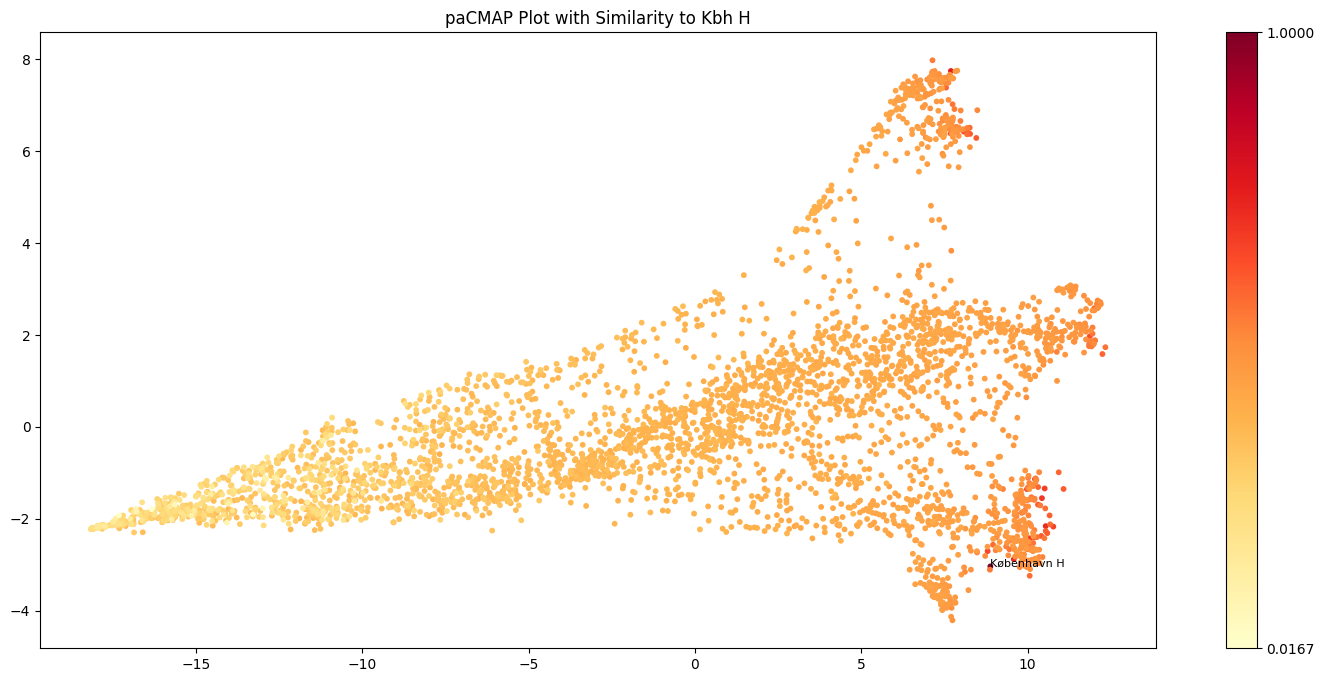

In [128]:

station_names = kbh_to_sim.keys()
# Get the first element
low_key, low_value = list(kbh_to_sim.items())[-1]
high_key, high_value = next(iter(kbh_to_sim.items()))

print("low", low_key, "  ", low_value)
print("high", high_key, "  ", high_value)
norm = Normalize(vmin=low_value, vmax=high_value)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

grayscale_values = [(kbh_to_sim[station]) for station in station_names]
# Plot the stations using paCMAP with grayscale colors
scatter = plt.scatter(proj_pacmap[:, 0], proj_pacmap[:, 1], c=grayscale_values, cmap='YlOrRd', s=10, alpha=1.0)

# Set the colorbar
colorbar = plt.colorbar(scatter, ax=ax)

# Manually set colorbar ticks and labels
colorbar.set_ticks([high_value, low_value])  # Adjust these as needed based on your scale

kbh_idx = journey_idx['København H']
#ADD LABEL TO JUST KØBENHAVN H
plt.text(proj_pacmap[kbh_index, 0], proj_pacmap[kbh_index, 1], 'København H', fontsize=8, ha='left')

plt.title('paCMAP Plot with Similarity to Kbh H')
plt.show()


### Rued Langgaards Vej validation on cosine embedding

In [50]:
list_rued_sim = model.wv.similar_by_key('Rued Langgaards Vej', topn=4000)

rued_to_sim = {"Rued Langgaards Vej": 1.0}
for location, sim in list_rued_sim:
    rued_to_sim[location] = sim

rued_to_sim

{'Rued Langgaards Vej': 1.0,
 'Krokodillegade': 0.941950261592865,
 'Gunløgsgade': 0.929219663143158,
 'Smørumvej': 0.9236794114112854,
 'Dæmningen': 0.9234192967414856,
 'Vennemindevej': 0.9221628308296204,
 'Fælledparken Skatepark': 0.9207092523574829,
 'Mosesvinget': 0.9200780391693115,
 'Det Nye Emdrupborg Kollegium': 0.9198076128959656,
 'Dyssegårdsvej': 0.918389618396759,
 'Adolph Steens Alle': 0.9172426462173462,
 'Bispebjerg Parkallé': 0.9136267304420471,
 'Mosevangen': 0.9121113419532776,
 'Druehaven': 0.911362886428833,
 'Gustav Johannsens Vej': 0.9113001823425293,
 'Skyttegårdvej': 0.9112046957015991,
 'Charlotte Muncks Vej': 0.9107897877693176,
 'Kagsbro': 0.9102784395217896,
 'Plantevej': 0.9101508259773254,
 'Junggreensvej': 0.9092990756034851,
 'Rigensgade': 0.9092826247215271,
 'Ole Maaløes Vej': 0.9078429937362671,
 'Kærskiftevej': 0.9077015519142151,
 'Heinesgade': 0.9075583815574646,
 'Adriansvej': 0.9074336290359497,
 'Sankt Markus Plads': 0.9061188101768494,
 'Valb

low Rued Langgaards Vej    1.0
high Den Ukrainske Ambassade    0.06156621500849724


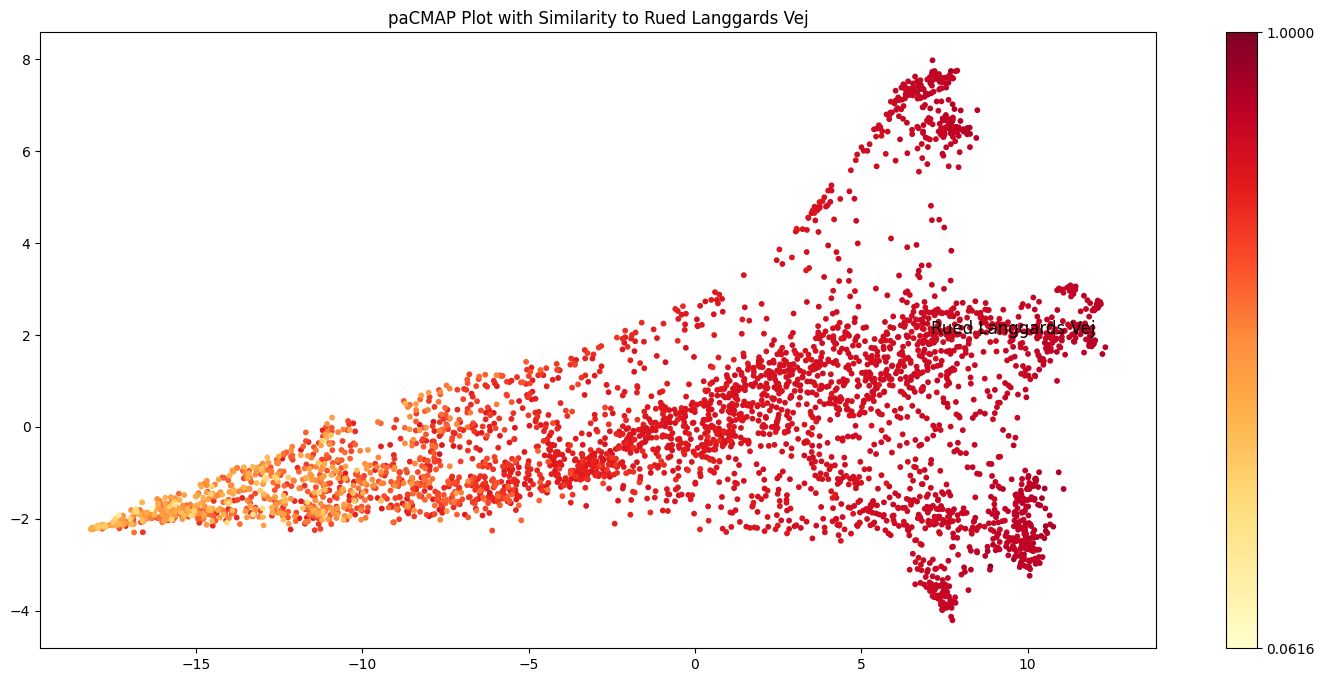

In [132]:

station_names = rued_to_sim.keys()
# Get the first element
low_key, low_value = next(iter(rued_to_sim.items()))
high_key, high_value = list(rued_to_sim.items())[-1]

print("low", low_key, "  ", low_value)
print("high", high_key, "  ", high_value)
norm = Normalize(vmin=low_value, vmax=high_value)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

grayscale_values = [(rued_to_sim[station]) for station in station_names]
# Plot the stations using paCMAP with grayscale colors
scatter = plt.scatter(proj_pacmap[:, 0], proj_pacmap[:, 1], c=grayscale_values, cmap='YlOrRd', s=10, alpha=1.0)

# Set the colorbar
colorbar = plt.colorbar(scatter, ax=ax)

# Manually set colorbar ticks and labels
colorbar.set_ticks([high_value, low_value])  # Adjust these as needed based on your scale


rued_idx = journey_idx['Rued Langgaards Vej']
#ADD LABEL TO JUST RUED LANGGAARDS VEJ
plt.text(proj_pacmap[rued_idx, 0], proj_pacmap[rued_idx, 1], 'Rued Langgards Vej', fontsize=12, ha='left')

plt.title('paCMAP Plot with Similarity to Rued Langgards Vej')
plt.show()


### Æblehaven validation on cosine embedding

In [56]:
list_æble_sim = model.wv.similar_by_key('Æblehaven', topn=4000)

æble_to_sim = {"Æblehaven": 1.0}
for location, sim in list_æble_sim:
    æble_to_sim[location] = sim

æble_to_sim

{'Æblehaven': 1.0,
 'Martin Luther Kings Vej': 0.9464658498764038,
 'V.A. Borgens Vej': 0.9420552253723145,
 'Marguerite Vibys Plads': 0.9386144876480103,
 'Skoubogade': 0.9379590153694153,
 'Støbegodsvej': 0.9366241693496704,
 'Nobis Hotel': 0.9366217851638794,
 'Lauravej': 0.9359109997749329,
 'Lykkesholms Allé': 0.9359049797058105,
 'Prins Constantins Vej': 0.9356565475463867,
 'Vor Frelsers Kirke': 0.9331955313682556,
 'Ved Kanalen': 0.9329544305801392,
 'Langøgade': 0.9327868223190308,
 'Vestbanevej': 0.9324917197227478,
 'Kulturhuset Indre By': 0.932479739189148,
 'Bratskovvej': 0.9310116767883301,
 'Krügersgade': 0.9308428168296814,
 'Priorvej': 0.9302312731742859,
 'Allersgade': 0.9299588799476624,
 'Kvæsthusbroen': 0.9293764233589172,
 'Hothers Plads': 0.9290462732315063,
 'Grundtvigsvej': 0.9289167523384094,
 'Brysselgade': 0.9286782145500183,
 'Nærumgade': 0.9283057451248169,
 'Gartnerivej': 0.9276339411735535,
 'Tivolislottet': 0.9263295531272888,
 'Lindebugten': 0.92617779

low Den Ukrainske Ambassade    0.10392951965332031
high Æblehaven    1.0


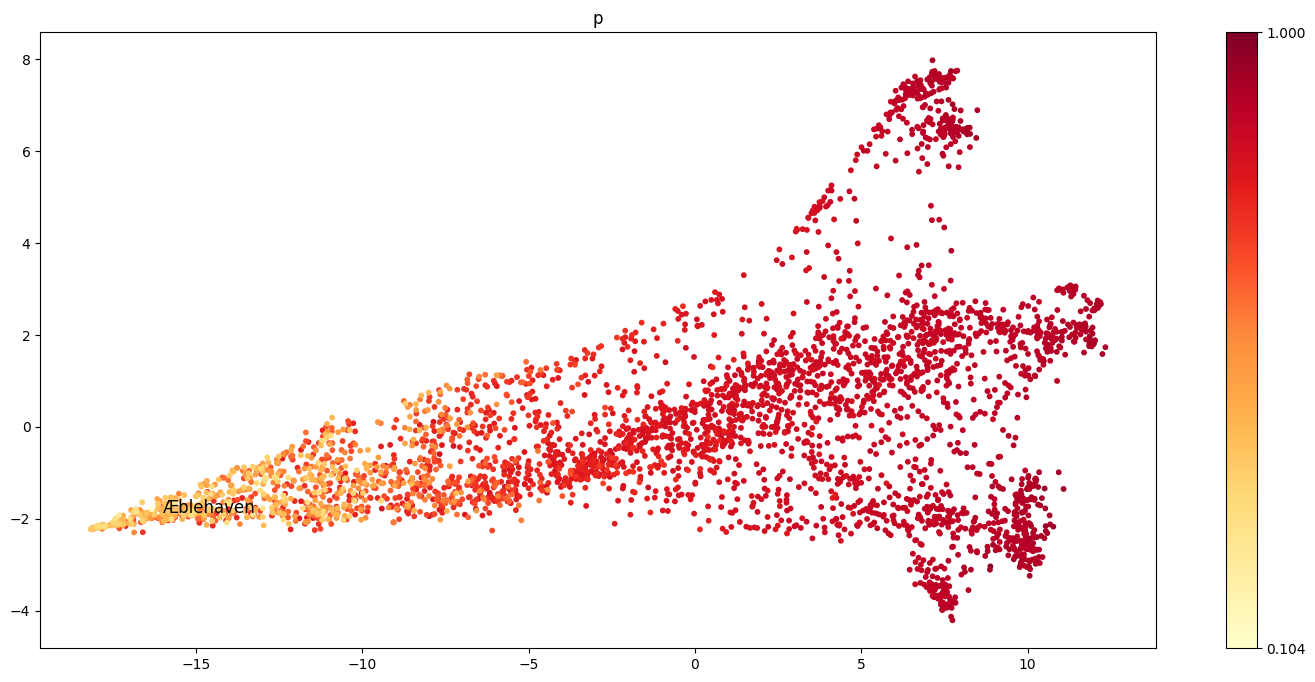

In [133]:

station_names = æble_to_sim.keys()
# Get the first element
low_key, low_value = list(æble_to_sim.items())[-1]
high_key, high_value = next(iter(æble_to_sim.items()))

print("low", low_key, "  ", low_value)
print("high", high_key, "  ", high_value)
norm = Normalize(vmin=low_value, vmax=high_value)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

grayscale_values = [(æble_to_sim[station]) for station in station_names]
scatter = plt.scatter(proj_pacmap[:, 0], proj_pacmap[:, 1], c=grayscale_values, cmap='YlOrRd', s=10, alpha=1.0)

# Set the colorbar
colorbar = plt.colorbar(scatter, ax=ax)

# Manually set colorbar ticks and labels
colorbar.set_ticks([high_value, low_value])  # Adjust these as needed based on your scale

æble_idx = journey_idx['Æblehaven']
#ADD LABEL TO JUST RUED LANGGAARDS VEJ
plt.text(proj_pacmap[æble_idx, 0], proj_pacmap[æble_idx, 1], 'Æblehaven', fontsize=12, ha='left')

plt.title('p')
plt.show()


__________________________________________________________________________________________________________________________________________________________

# CHOOSING MODEL AND DIMENSIONS


In [59]:
model_10000_100=word2vec.Word2Vec.load('../Data/Models/model_10000e_100d.model')
model_10000_100_lowest=word2vec.Word2Vec.load('../Data/Models/model_10000e_100d_lowest_loss.model')
model_2000_300=word2vec.Word2Vec.load('../Data/Models/best_model_new.model') 
model_2000_100=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_2000e.model')
model_50_300=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_300d.model')
model_50_100=word2vec.Word2Vec.load('../Data/Models/model_5325_locations_50e_100d.model')
model_10_100= word2vec.Word2Vec.load('../Data/Models/model_10e_100d.model')
model_5_100= word2vec.Word2Vec.load('../Data/Models/model_5e_100d.model')
model_2_100= word2vec.Word2Vec.load('../Data/Models/model_2e_100d.model')
model_1_100= word2vec.Word2Vec.load('../Data/Models/model_1e_100d.model')

Plotting all models with paCMAP

In [60]:
X = model_10000_100.wv.vectors
embedding_10000_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10000_100 = embedding_10000_100.fit_transform(X, init="pca")

X1 = model_10000_100_lowest.wv.vectors
embedding_10000_100_lowest = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10000_100_lowest = embedding_10000_100_lowest.fit_transform(X1, init="pca")

X2 = model_2000_300.wv.vectors
embedding_2000_300 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2000_300 = embedding_2000_300.fit_transform(X2, init="pca")

X3 = model_2000_100.wv.vectors
embedding_2000_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2000_100 = embedding_2000_100.fit_transform(X3, init="pca")

X4 = model_50_300.wv.vectors
embedding_50_300 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_50_300 = embedding_50_300.fit_transform(X4, init="pca")

X5 = model_50_100.wv.vectors
embedding_50_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_50_100 = embedding_50_100.fit_transform(X5, init="pca")

X6 = model_10_100.wv.vectors
embedding_10_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_10_100 = embedding_10_100.fit_transform(X6, init="pca")

X7 = model_5_100.wv.vectors
embedding_5_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_5_100 = embedding_5_100.fit_transform(X7, init="pca")

X8 = model_2_100.wv.vectors
embedding_2_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_2_100 = embedding_2_100.fit_transform(X8, init="pca")

X9 = model_1_100.wv.vectors
embedding_1_100 = pacmap.PaCMAP(n_components=2, n_neighbors=20, MN_ratio=0.5, FP_ratio=2.0) 
proj_1_100 = embedding_1_100.fit_transform(X9, init="pca")


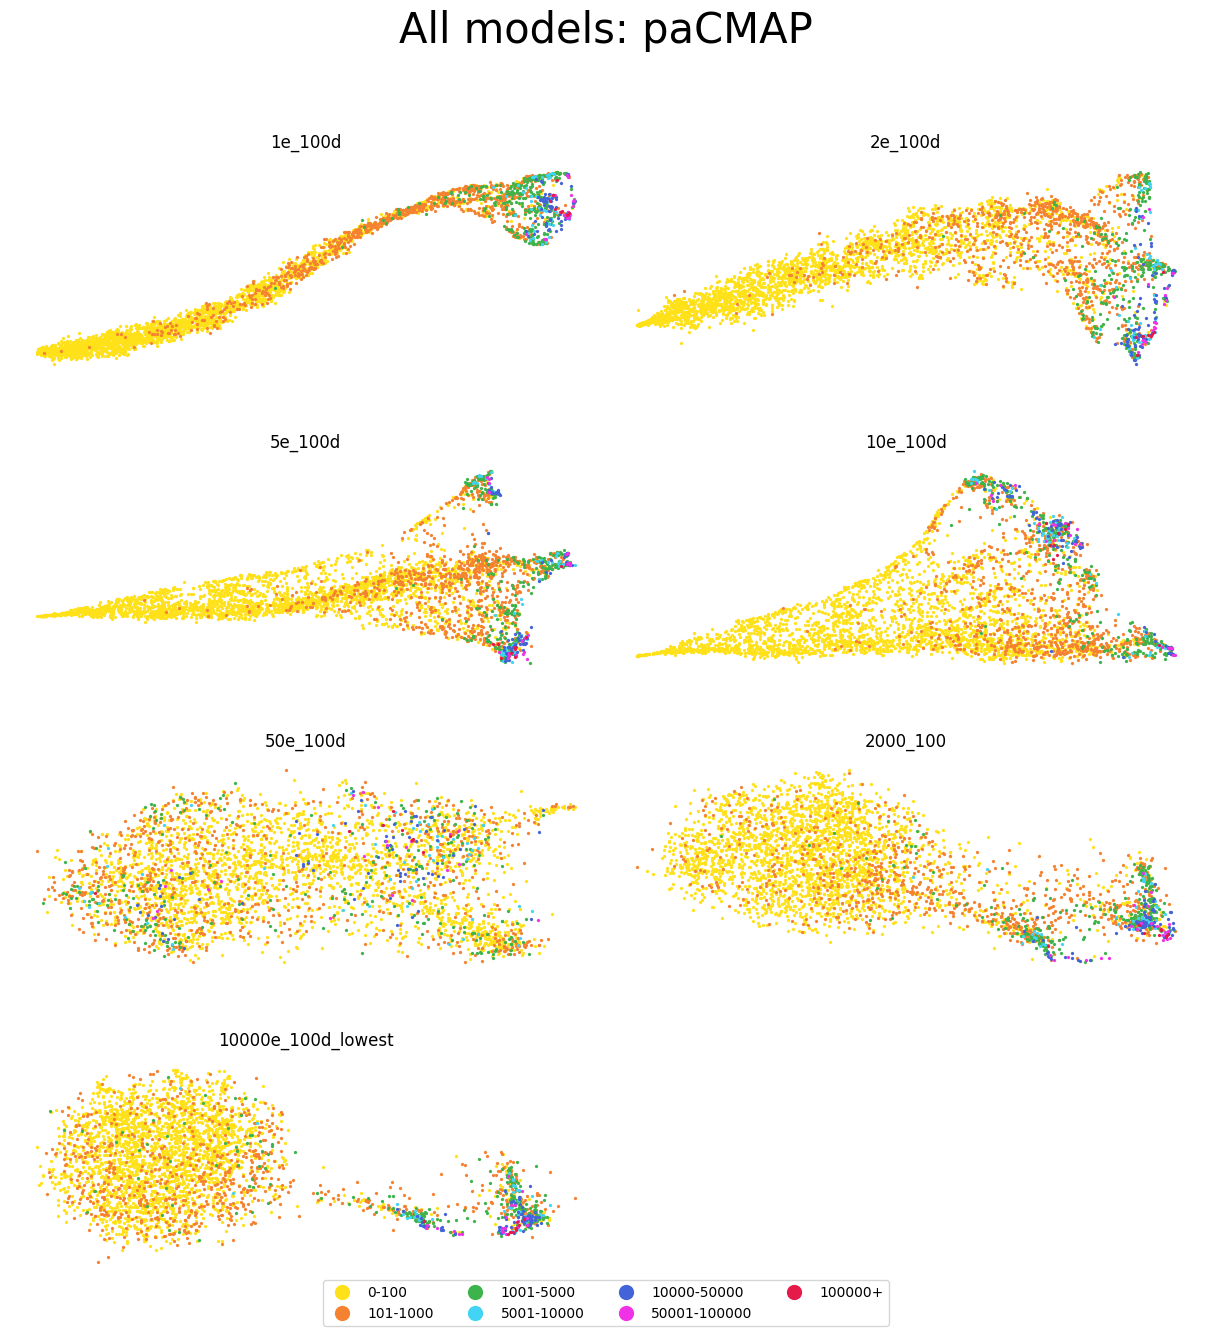

In [96]:
# Define color palette for zip codes
count_colors = {}  # Dictionary to map zip codes to colors
unique_count_codes = sorted(counts_to_labels.keys())
num_colors = len(unique_count_codes) #change this
#color_palette = plt.cm.get_cmap('tab20', num_colors)  # Choose a colormap
color_palette = ['#ffe119', '#f58231', '#3cb44b', '#42d4f4', '#4363d8', '#f032e6', '#e6194b']
#print("number of unique zips: ", num_colors)

for idx, count_code in enumerate(unique_count_codes):
    count_colors[count_code] = color_palette[idx]

# Create the plots
fig, ax = plt.subplots(4, 2, figsize=(12, 12), layout='constrained', gridspec_kw={'wspace': 0.0, 'hspace': 0.2})
xs = [proj_1_100, proj_2_100, proj_5_100, proj_10_100, proj_50_100, proj_2000_100, proj_10000_100_lowest]  # Use xs to select different dimensionality reduction results
ts = ["1e_100d", "2e_100d", "5e_100d","10e_100d", "50e_100d", "2000_100", "10000e_100d_lowest"]
s = 0
fig.delaxes(ax[3, 1])

for row in ax:
    for col in row:
        try:
            col.set_title(ts[s], fontsize=12, pad=10)
            for current_count_code in unique_count_codes:
                relevant_addresses = []
                for address, count_code in address_cluster_count.items():
                    if address in journey_ids:
                        if current_count_code == count_code:
                            relevant_addresses.append(address)

                relevant_journeys_count = [journey_id for journey_id in relevant_addresses]
                col.scatter(
                    [xs[s][journey_idx[journey_id]][0] for journey_id in relevant_journeys_count],
                    [xs[s][journey_idx[journey_id]][1] for journey_id in relevant_journeys_count],
                    lw=0.1, s=5, label=current_count_code, c=count_colors[current_count_code]
                )
            #  # Add labels to stations makes it impossible to read 
            #     for journey_id in relevant_journeys_zip:
            #         x_coord = xs[s][journey_idx[journey_id]][0]
            #         y_coord = xs[s][journey_idx[journey_id]][1]
            #         col.text(x_coord, y_coord, journey_id, fontsize=8)  # Adjust fontsize as needed
                
            s += 1
            col.axis('off')
        except IndexError:
            continue


# Custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=12, markerfacecolor=count_colors[count_code], label=counts_to_labels[count_code]) for count_code in unique_count_codes]
fig.legend(handles= handles, loc="outside lower center", ncol=4)
fig.suptitle('All models: paCMAP', fontsize=30, y=1.1)
plt.show()
